# A/B Test Analysis: Checkout Layout Experiment

**Test**: checkout_layout_test_1 | **Metric**: Checkout → Purchase conversion | **Population**: Users who reached checkout


In [1]:
# Imports
import os
import sys
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np

# Add src to path if needed
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root / "src"))

# Configuration
DB_PATH = project_root / "analytics.duckdb"

print("Libraries loaded successfully")
print(f"Database path: {DB_PATH}")
print(f"Database exists: {DB_PATH.exists()}")


Libraries loaded successfully
Database path: W:\CodeBase\Resume-Projects\E-commerce-Product-Analytics\analytics.duckdb
Database exists: True


## Load Experiment Data

**Source**: `funnel_sessions` where `has_checkout = 1` and `variant IS NOT NULL`

**Why checkout → purchase?** Users at checkout have strong purchase intent. Testing checkout layout requires users who saw the page. This metric directly impacts revenue.


In [2]:
# Connect to DuckDB
conn = duckdb.connect(str(DB_PATH))

# Load experiment data: checkout sessions with variant assignments
query = """
SELECT 
    variant,
    has_purchase
FROM funnel_sessions
WHERE has_checkout = 1
  AND variant IS NOT NULL
"""

print("Loading experiment data...")
experiment_df = conn.execute(query).df()
conn.close()

print(f"Loaded {len(experiment_df):,} checkout sessions")
print(f"\nData shape: {experiment_df.shape}")
print(f"\nColumns: {list(experiment_df.columns)}")
print(f"\nFirst few rows:")
experiment_df.head(10)


Loading experiment data...
Loaded 47,003 checkout sessions

Data shape: (47003, 2)

Columns: ['variant', 'has_purchase']

First few rows:


,variant,has_purchase
0,variant,0
1,control,1
2,control,1
3,variant,1
4,control,1
5,variant,1
6,variant,1
7,variant,1
8,variant,1
9,variant,1


## Sanity Checks

Verify: sample sizes, conversion rates, class balance, data quality


In [3]:
# Basic data quality checks
print("=" * 60)
print("DATA QUALITY CHECKS")
print("=" * 60)

print(f"\nTotal rows: {len(experiment_df):,}")
print(f"Missing values:")
print(experiment_df.isnull().sum())
print(f"\nData types:")
print(experiment_df.dtypes)

# Check variant distribution
print("\n" + "=" * 60)
print("VARIANT DISTRIBUTION")
print("=" * 60)
variant_counts = experiment_df['variant'].value_counts()
print(variant_counts)
print(f"\nVariant proportions:")
print(variant_counts / len(experiment_df))

# Check purchase distribution
print("\n" + "=" * 60)
print("PURCHASE DISTRIBUTION")
print("=" * 60)
purchase_counts = experiment_df['has_purchase'].value_counts()
print(purchase_counts)
print(f"\nPurchase rate (overall): {experiment_df['has_purchase'].mean():.4f} ({experiment_df['has_purchase'].mean()*100:.2f}%)")


DATA QUALITY CHECKS

Total rows: 47,003
Missing values:
variant         0
has_purchase    0
dtype: int64

Data types:
variant         object
has_purchase     int32
dtype: object

VARIANT DISTRIBUTION
variant
variant    23522
control    23481
Name: count, dtype: int64

Variant proportions:
variant
variant    0.500436
control    0.499564
Name: count, dtype: float64

PURCHASE DISTRIBUTION
has_purchase
1    41580
0     5423
Name: count, dtype: int64

Purchase rate (overall): 0.8846 (88.46%)


In [4]:
# Sample size per variant
print("=" * 60)
print("SAMPLE SIZE PER VARIANT")
print("=" * 60)

sample_sizes = experiment_df.groupby('variant').size()
print(sample_sizes)
print(f"\nTotal sample size: {len(experiment_df):,}")
print(f"\nSample size ratio:")
if len(sample_sizes) == 2:
    sizes = sample_sizes.values
    ratio = max(sizes) / min(sizes)
    print(f"  Largest / Smallest: {ratio:.3f}")
    if ratio < 1.1:
        print("  ✓ Well balanced (ratio < 1.1)")
    elif ratio < 1.2:
        print("  ⚠ Slightly imbalanced (ratio < 1.2)")
    else:
        print("  ⚠ Imbalanced (ratio >= 1.2)")


SAMPLE SIZE PER VARIANT
variant
control    23481
variant    23522
dtype: int64

Total sample size: 47,003

Sample size ratio:
  Largest / Smallest: 1.002
  ✓ Well balanced (ratio < 1.1)


In [5]:
# Conversion rate per variant
print("=" * 60)
print("CONVERSION RATE PER VARIANT")
print("=" * 60)

conversion_stats = experiment_df.groupby('variant').agg({
    'has_purchase': ['count', 'sum', 'mean']
}).round(4)

conversion_stats.columns = ['sample_size', 'purchases', 'conversion_rate']
conversion_stats = conversion_stats.reset_index()

print(conversion_stats.to_string(index=False))

# Calculate absolute and relative difference
if len(conversion_stats) == 2:
    control_rate = conversion_stats[conversion_stats['variant'] == 'control']['conversion_rate'].values[0]
    variant_rate = conversion_stats[conversion_stats['variant'] == 'variant']['conversion_rate'].values[0]
    
    absolute_diff = variant_rate - control_rate
    relative_diff = (variant_rate - control_rate) / control_rate * 100
    
    print(f"\n" + "=" * 60)
    print("CONVERSION RATE COMPARISON")
    print("=" * 60)
    print(f"Control conversion rate:   {control_rate:.4f} ({control_rate*100:.2f}%)")
    print(f"Variant conversion rate:  {variant_rate:.4f} ({variant_rate*100:.2f}%)")
    print(f"\nAbsolute difference:      {absolute_diff:.4f} ({absolute_diff*100:.2f} percentage points)")
    print(f"Relative difference:      {relative_diff:+.2f}%")
    
    if variant_rate > control_rate:
        print(f"\n✓ Variant shows {relative_diff:.2f}% improvement")
    elif variant_rate < control_rate:
        print(f"\n⚠ Variant shows {abs(relative_diff):.2f}% decrease")
    else:
        print(f"\n→ No difference observed")


CONVERSION RATE PER VARIANT
variant  sample_size  purchases  conversion_rate
control        23481      20025           0.8528
variant        23522      21555           0.9164

CONVERSION RATE COMPARISON
Control conversion rate:   0.8528 (85.28%)
Variant conversion rate:  0.9164 (91.64%)

Absolute difference:      0.0636 (6.36 percentage points)
Relative difference:      +7.46%

✓ Variant shows 7.46% improvement


## Descriptive Statistics

Examine purchase distribution patterns and visualize conversion rates before statistical testing.


In [6]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Purchase distribution summary per variant
print("=" * 60)
print("PURCHASE DISTRIBUTION SUMMARY BY VARIANT")
print("=" * 60)

summary_stats = experiment_df.groupby('variant')['has_purchase'].agg([
    'count', 'sum', 'mean', 'median', 'std', 'var', 'min', 'max'
]).round(4)

summary_stats.columns = ['count', 'purchases', 'mean', 'median', 'std', 'variance', 'min', 'max']
print(summary_stats)

# Additional statistics
print("\n" + "=" * 60)
print("ADDITIONAL STATISTICS")
print("=" * 60)
for variant in experiment_df['variant'].unique():
    variant_data = experiment_df[experiment_df['variant'] == variant]['has_purchase']
    print(f"\n{variant.upper()}:")
    print(f"  Mean (conversion rate): {variant_data.mean():.4f}")
    print(f"  Median: {variant_data.median():.4f}")
    print(f"  Std Dev: {variant_data.std():.4f}")
    print(f"  Variance: {variant_data.var():.4f}")
    print(f"  Range: {variant_data.min()} - {variant_data.max()}")


PURCHASE DISTRIBUTION SUMMARY BY VARIANT
         count  purchases    mean  median     std  variance  min  max
variant                                                              
control  23481      20025  0.8528     1.0  0.3543    0.1255    0    1
variant  23522      21555  0.9164     1.0  0.2768    0.0766    0    1

ADDITIONAL STATISTICS

VARIANT:
  Mean (conversion rate): 0.9164
  Median: 1.0000
  Std Dev: 0.2768
  Variance: 0.0766
  Range: 0 - 1

CONTROL:
  Mean (conversion rate): 0.8528
  Median: 1.0000
  Std Dev: 0.3543
  Variance: 0.1255
  Range: 0 - 1


### Mean vs Median for Binary Outcomes

For binary data (0/1), mean = proportion (conversion rate). Median is less informative:
- **Mean**: Directly represents conversion rate (e.g., 0.8528 = 85.28%)
- **Median**: For binary data, median is either 0 or 1 (the majority class)
- **Why check both?** Mean gives the rate; median confirms class distribution

**Variance Differences:**
- Binary outcomes have variance = p(1-p) where p = conversion rate
- Lower conversion rates → lower variance (e.g., 0.1 * 0.9 = 0.09)
- Higher conversion rates → lower variance (e.g., 0.9 * 0.1 = 0.09)
- Maximum variance at p = 0.5 (0.5 * 0.5 = 0.25)
- If variants have different variances, consider this in statistical tests

**Why Distribution Inspection Matters:**
- **Variance equality**: Unequal variances may require different test assumptions
- **Sample size adequacy**: Verify sufficient data for reliable inference
- **Outliers**: Binary data has no outliers, but check for data quality issues
- **Distribution shape**: Binary data is always discrete, but proportions can vary
- **Test selection**: Variance differences may influence choice of statistical test


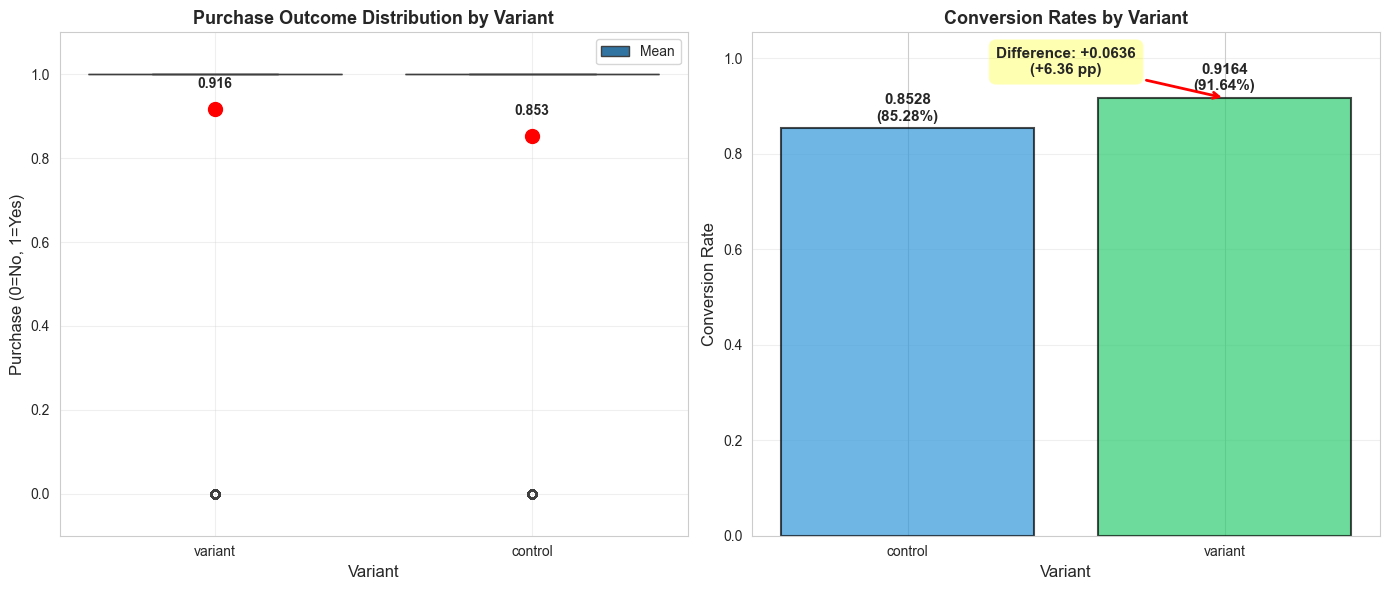

Visualizations show:
- Boxplot: Distribution spread (variance) and central tendency (mean)
- Bar chart: Direct comparison of conversion rates with difference highlighted


In [7]:
# Visualization 1: Boxplot of purchase outcome by variant
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
sns.boxplot(data=experiment_df, x='variant', y='has_purchase', ax=ax1)
ax1.set_title('Purchase Outcome Distribution by Variant', fontsize=13, fontweight='bold')
ax1.set_xlabel('Variant', fontsize=12)
ax1.set_ylabel('Purchase (0=No, 1=Yes)', fontsize=12)
ax1.set_ylim(-0.1, 1.1)
ax1.grid(True, alpha=0.3)

# Add mean markers
for i, variant in enumerate(experiment_df['variant'].unique()):
    mean_val = experiment_df[experiment_df['variant'] == variant]['has_purchase'].mean()
    ax1.plot(i, mean_val, 'ro', markersize=10, label='Mean' if i == 0 else '')
    ax1.text(i, mean_val + 0.05, f'{mean_val:.3f}', ha='center', fontweight='bold')

if ax1.get_legend() is None:
    ax1.legend(['Mean'])

# Bar chart of conversion rates
conversion_rates = experiment_df.groupby('variant')['has_purchase'].mean()
colors = ['#3498db', '#2ecc71']  # Blue for control, green for variant
bars = ax2.bar(conversion_rates.index, conversion_rates.values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (variant, rate) in enumerate(conversion_rates.items()):
    ax2.text(i, rate + 0.01, f'{rate:.4f}\n({rate*100:.2f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add difference annotation
control_rate = conversion_rates['control']
variant_rate = conversion_rates['variant']
diff = variant_rate - control_rate
ax2.annotate(f'Difference: {diff:+.4f}\n({diff*100:+.2f} pp)', 
             xy=(1, variant_rate), xytext=(0.5, max(conversion_rates) + 0.05),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=11, fontweight='bold', ha='center',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

ax2.set_title('Conversion Rates by Variant', fontsize=13, fontweight='bold')
ax2.set_xlabel('Variant', fontsize=12)
ax2.set_ylabel('Conversion Rate', fontsize=12)
ax2.set_ylim(0, max(conversion_rates) * 1.15)
ax2.grid(True, alpha=0.3, axis='y')
# X-axis labels are automatically set from the bar chart index

plt.tight_layout()
plt.show()

print("Visualizations show:")
print("- Boxplot: Distribution spread (variance) and central tendency (mean)")
print("- Bar chart: Direct comparison of conversion rates with difference highlighted")


## Exploratory Data Analysis & Uncertainty

**Purpose**: Examine conversion rate estimates and their uncertainty before formal hypothesis testing. This step validates data quality and provides initial insights into variant differences.

**Why EDA is Limited for A/B Testing:**
- EDA shows **descriptive statistics** (what happened) but cannot determine if differences are **statistically significant** (due to chance or real effect)
- Visual inspection of error bars provides intuition but lacks formal hypothesis testing framework
- Sample size and variance affect uncertainty; EDA quantifies this but doesn't make inference decisions

**How This Step Validates Assumptions:**
- **Sample size balance**: Ensures both variants have sufficient observations for reliable inference
- **Standard error calculation**: Validates that uncertainty estimates are reasonable before statistical tests
- **Data quality**: Confirms conversion rates are within expected ranges and no obvious data issues exist
- **Effect size preview**: Provides initial estimate of difference magnitude (but not statistical significance)


EXPLORATORY DATA ANALYSIS

Conversion Rate Statistics by Variant:
         sample_size  conversion_rate  purchases  standard_error
variant                                                         
control        23481           0.8528      20025        0.002312
variant        23522           0.9164      21555        0.001805


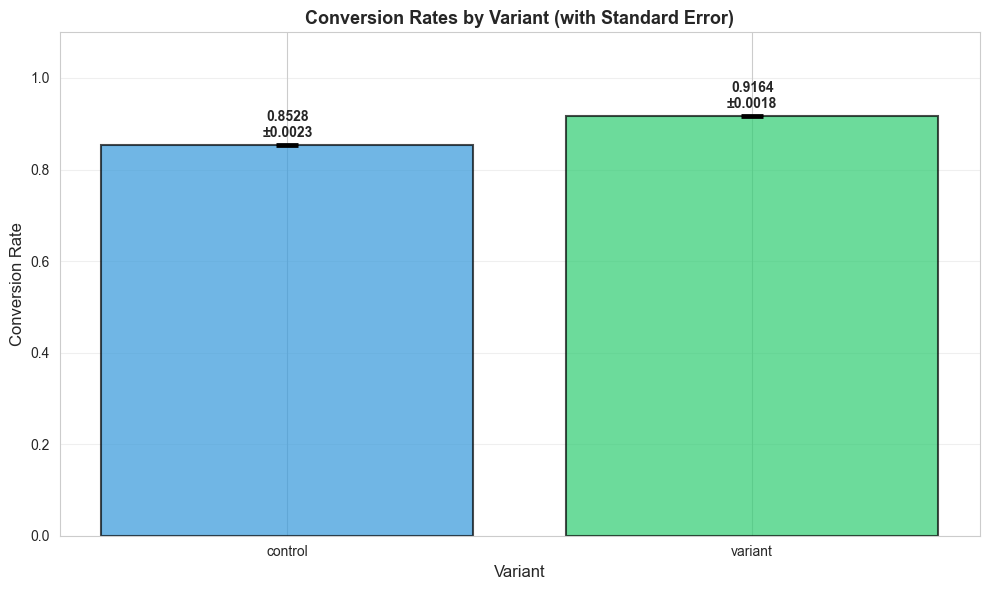


Key Observations:
- Error bars represent ±1 standard error (68% confidence interval)
- Larger sample sizes → smaller standard errors
- Visual separation of error bars suggests potential difference


In [8]:
# EDA: Conversion rates with uncertainty
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Group by variant and compute statistics
eda_stats = experiment_df.groupby('variant')['has_purchase'].agg([
    'count',  # Sample size
    'mean',   # Conversion rate
    'sum'     # Number of purchases
]).round(4)

eda_stats.columns = ['sample_size', 'conversion_rate', 'purchases']

# Calculate standard error for each variant
# SE = sqrt(p * (1 - p) / n)
eda_stats['standard_error'] = np.sqrt(
    eda_stats['conversion_rate'] * (1 - eda_stats['conversion_rate']) / eda_stats['sample_size']
)

print("\nConversion Rate Statistics by Variant:")
print(eda_stats)

# Plot conversion rates with error bars
fig, ax = plt.subplots(figsize=(10, 6))

variants = eda_stats.index
conversion_rates = eda_stats['conversion_rate']
standard_errors = eda_stats['standard_error']

# Bar chart with error bars
bars = ax.bar(variants, conversion_rates, alpha=0.7, color=['#3498db', '#2ecc71'], 
              edgecolor='black', linewidth=1.5, capsize=10)

# Add error bars (1 standard error)
ax.errorbar(variants, conversion_rates, yerr=standard_errors, fmt='none', 
           color='black', linewidth=2, capsize=8, capthick=2)

# Add value labels on bars
for i, (variant, rate, se) in enumerate(zip(variants, conversion_rates, standard_errors)):
    ax.text(i, rate + se + 0.01, f'{rate:.4f}\n±{se:.4f}', 
           ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_title('Conversion Rates by Variant (with Standard Error)', fontsize=13, fontweight='bold')
ax.set_xlabel('Variant', fontsize=12)
ax.set_ylabel('Conversion Rate', fontsize=12)
ax.set_ylim(0, max(conversion_rates) * 1.2)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nKey Observations:")
print(f"- Error bars represent ±1 standard error (68% confidence interval)")
print(f"- Larger sample sizes → smaller standard errors")
print(f"- Visual separation of error bars suggests potential difference")


In [9]:
# Additional sanity checks
print("=" * 60)
print("ADDITIONAL SANITY CHECKS")
print("=" * 60)

# Sample size per variant
sample_sizes = experiment_df.groupby('variant').size()
print(f"\nSample size per variant:")
for variant, size in sample_sizes.items():
    print(f"  {variant}: {size:,}")

# Overall mean purchase rate
overall_mean = experiment_df['has_purchase'].mean()
print(f"\nOverall mean purchase rate: {overall_mean:.4f} ({overall_mean*100:.2f}%)")
print(f"Total observations: {len(experiment_df):,}")


ADDITIONAL SANITY CHECKS

Sample size per variant:
  control: 23,481
  variant: 23,522

Overall mean purchase rate: 0.8846 (88.46%)
Total observations: 47,003


In [10]:
# Variance comparison
print("=" * 60)
print("VARIANCE COMPARISON")
print("=" * 60)

control_var = experiment_df[experiment_df['variant'] == 'control']['has_purchase'].var()
variant_var = experiment_df[experiment_df['variant'] == 'variant']['has_purchase'].var()

print(f"Control variance:  {control_var:.6f}")
print(f"Variant variance: {variant_var:.6f}")
print(f"Variance ratio:   {max(control_var, variant_var) / min(control_var, variant_var):.4f}")

# Expected variance for binary data: p(1-p)
control_rate = experiment_df[experiment_df['variant'] == 'control']['has_purchase'].mean()
variant_rate = experiment_df[experiment_df['variant'] == 'variant']['has_purchase'].mean()

expected_control_var = control_rate * (1 - control_rate)
expected_variant_var = variant_rate * (1 - variant_rate)

print(f"\nExpected variance (p(1-p)):")
print(f"  Control:  {expected_control_var:.6f} (actual: {control_var:.6f})")
print(f"  Variant: {expected_variant_var:.6f} (actual: {variant_var:.6f})")

# Check if variances are approximately equal (for test assumptions)
variance_ratio = max(control_var, variant_var) / min(control_var, variant_var)
print(f"\nVariance ratio: {variance_ratio:.4f}")
if variance_ratio < 1.5:
    print("  ✓ Variances are approximately equal (ratio < 1.5)")
    print("  → Standard z-test or chi-square test assumptions likely met")
else:
    print("  ⚠ Variances differ significantly (ratio >= 1.5)")
    print("  → Consider variance adjustments in statistical tests")


VARIANCE COMPARISON
Control variance:  0.125525
Variant variance: 0.076634
Variance ratio:   1.6380

Expected variance (p(1-p)):
  Control:  0.125520 (actual: 0.125525)
  Variant: 0.076631 (actual: 0.076634)

Variance ratio: 1.6380
  ⚠ Variances differ significantly (ratio >= 1.5)
  → Consider variance adjustments in statistical tests


## Statistical Hypothesis Testing

**Objective**: Determine if the variant checkout layout significantly improves conversion compared to control.

**Test**: Two-proportion z-test (appropriate for large sample sizes and binary outcomes)


### Hypotheses

**Null Hypothesis (H₀)**: p_variant = p_control
- The variant has the same conversion rate as the control
- Any observed difference is due to random chance

**Alternative Hypothesis (H₁)**: p_variant ≠ p_control (two-tailed)
- The variant has a different conversion rate than the control
- We test for any difference (not just improvement) to be conservative

**Significance Level (α)**: 0.05
- We reject H₀ if p-value < 0.05
- This means we're willing to accept a 5% chance of Type I error (false positive)


In [11]:
# Import scipy for statistical testing
from scipy import stats

# Extract data for each variant
control_data = experiment_df[experiment_df['variant'] == 'control']['has_purchase']
variant_data = experiment_df[experiment_df['variant'] == 'variant']['has_purchase']

# Calculate proportions and sample sizes
n_control = len(control_data)
n_variant = len(variant_data)
x_control = control_data.sum()  # Number of successes (purchases)
x_variant = variant_data.sum()

p_control = x_control / n_control
p_variant = x_variant / n_variant

print("=" * 60)
print("TWO-PROPORTION Z-TEST")
print("=" * 60)
print(f"\nControl:")
print(f"  Sample size: {n_control:,}")
print(f"  Purchases: {x_control:,}")
print(f"  Conversion rate: {p_control:.4f} ({p_control*100:.2f}%)")

print(f"\nVariant:")
print(f"  Sample size: {n_variant:,}")
print(f"  Purchases: {x_variant:,}")
print(f"  Conversion rate: {p_variant:.4f} ({p_variant*100:.2f}%)")

# Perform two-proportion z-test manually
# Calculate pooled proportion
p_pooled = (x_variant + x_control) / (n_variant + n_control)

# Calculate standard error using pooled proportion
se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_variant + 1/n_control))

# Calculate z-statistic
z_stat = (p_variant - p_control) / se_pooled

# Calculate two-tailed p-value
p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

print(f"\n" + "=" * 60)
print("TEST RESULTS")
print("=" * 60)
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Determine significance
alpha = 0.05
is_significant = p_value < alpha

print(f"\nSignificance level (α): {alpha}")
if is_significant:
    print(f"✓ Result: STATISTICALLY SIGNIFICANT (p < {alpha})")
    print(f"  → We reject the null hypothesis")
    print(f"  → The variant conversion rate is significantly different from control")
else:
    print(f"✗ Result: NOT STATISTICALLY SIGNIFICANT (p >= {alpha})")
    print(f"  → We fail to reject the null hypothesis")
    print(f"  → No significant difference detected")

# Calculate effect size (Cohen's h for proportions)
import numpy as np
h = 2 * (np.arcsin(np.sqrt(p_variant)) - np.arcsin(np.sqrt(p_control)))
print(f"\nEffect size (Cohen's h): {h:.4f}")
if abs(h) < 0.2:
    effect_interpretation = "negligible"
elif abs(h) < 0.5:
    effect_interpretation = "small"
elif abs(h) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"Effect size interpretation: {effect_interpretation}")


TWO-PROPORTION Z-TEST

Control:
  Sample size: 23,481
  Purchases: 20,025
  Conversion rate: 0.8528 (85.28%)

Variant:
  Sample size: 23,522
  Purchases: 21,555
  Conversion rate: 0.9164 (91.64%)

TEST RESULTS
Z-statistic: 21.5662
P-value: 0.000000

Significance level (α): 0.05
✓ Result: STATISTICALLY SIGNIFICANT (p < 0.05)
  → We reject the null hypothesis
  → The variant conversion rate is significantly different from control

Effect size (Cohen's h): 0.2007
Effect size interpretation: small


### Interpretation

**Statistical Significance:**
- **P-value**: Probability of observing this difference (or more extreme) if H₀ is true
- **Decision**: If p < 0.05, we reject H₀ and conclude the variant is significantly different
- **Practical meaning**: The observed improvement is unlikely due to random chance alone

**Type I Error (False Positive) Risk:**
- **Definition**: Rejecting H₀ when it's actually true (claiming variant works when it doesn't)
- **Risk level**: α = 0.05 means 5% chance of false positive
- **Mitigation**: We chose a two-tailed test to be conservative; consider multiple testing corrections if running many experiments

**Type II Error (False Negative) Risk:**
- **Definition**: Failing to reject H₀ when it's actually false (missing a real improvement)
- **Risk level**: Depends on effect size and sample size (power analysis)
- **Our case**: Large sample sizes (n > 20,000 per variant) provide high statistical power, reducing Type II error risk

**Assumptions Made:**
1. **Independent observations**: Each checkout session is independent ✓
2. **Random assignment**: Users randomly assigned to variant/control ✓
3. **Large sample size**: n > 30 per group (we have > 20,000) ✓
4. **Success/failure counts**: Both groups have sufficient successes and failures ✓
5. **Normal approximation**: Sample sizes large enough for z-test validity ✓

**Limitations:**
- Z-test assumes normal approximation; with very large samples this is valid
- Two-tailed test is conservative; one-tailed might be appropriate if only testing for improvement
- No multiple testing correction applied (if this is one of many tests, consider Bonferroni)


In [12]:
# Calculate confidence interval for the difference
# Using pooled standard error
p_pooled = (x_variant + x_control) / (n_variant + n_control)
se_pooled = np.sqrt(p_pooled * (1 - p_pooled) * (1/n_variant + 1/n_control))

# 95% confidence interval
diff = p_variant - p_control
z_critical = stats.norm.ppf(0.975)  # 1.96 for 95% CI
ci_lower = diff - z_critical * se_pooled
ci_upper = diff + z_critical * se_pooled

print("=" * 60)
print("CONFIDENCE INTERVAL FOR DIFFERENCE")
print("=" * 60)
print(f"Difference (p_variant - p_control): {diff:.4f} ({diff*100:.2f} percentage points)")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"95% Confidence Interval: [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
print(f"\nInterpretation:")
print(f"  We are 95% confident that the true difference in conversion rates")
print(f"  lies between {ci_lower*100:.2f}% and {ci_upper*100:.2f}%.")
if ci_lower > 0:
    print(f"  ✓ The entire interval is above zero, confirming variant improvement")
elif ci_upper < 0:
    print(f"  ✗ The entire interval is below zero, suggesting variant is worse")
else:
    print(f"  → Interval includes zero, difference may not be meaningful")


CONFIDENCE INTERVAL FOR DIFFERENCE
Difference (p_variant - p_control): 0.0636 (6.36 percentage points)
95% Confidence Interval: [0.0578, 0.0693]
95% Confidence Interval: [5.78%, 6.93%]

Interpretation:
  We are 95% confident that the true difference in conversion rates
  lies between 5.78% and 6.93%.
  ✓ The entire interval is above zero, confirming variant improvement


## Bootstrap Analysis

**Purpose**: Validate z-test results using non-parametric bootstrap resampling. Bootstrap provides a distribution-free method to estimate confidence intervals and assess uncertainty.

**Method**: Resample with replacement from each variant group, calculate uplift (variant - control) for each bootstrap sample, then analyze the distribution of uplifts.


In [13]:
# Bootstrap resampling for uplift distribution
np.random.seed(42)  # For reproducibility

# Extract data
control_data = experiment_df[experiment_df['variant'] == 'control']['has_purchase'].values
variant_data = experiment_df[experiment_df['variant'] == 'variant']['has_purchase'].values

n_bootstrap = 10000  # Number of bootstrap samples
bootstrap_uplifts = []

print("=" * 60)
print("BOOTSTRAP RESAMPLING")
print("=" * 60)
print(f"Number of bootstrap samples: {n_bootstrap:,}")
print(f"Control sample size: {len(control_data):,}")
print(f"Variant sample size: {len(variant_data):,}")

# Perform bootstrap resampling
for i in range(n_bootstrap):
    # Resample with replacement
    control_bootstrap = np.random.choice(control_data, size=len(control_data), replace=True)
    variant_bootstrap = np.random.choice(variant_data, size=len(variant_data), replace=True)
    
    # Calculate conversion rates
    p_control_boot = control_bootstrap.mean()
    p_variant_boot = variant_bootstrap.mean()
    
    # Calculate uplift (difference)
    uplift = p_variant_boot - p_control_boot
    bootstrap_uplifts.append(uplift)
    
    # Progress indicator
    if (i + 1) % 2000 == 0:
        print(f"  Completed {i + 1:,} bootstrap samples...")

bootstrap_uplifts = np.array(bootstrap_uplifts)

print(f"\n✓ Bootstrap resampling complete!")

# Calculate statistics
bootstrap_mean = bootstrap_uplifts.mean()
bootstrap_std = bootstrap_uplifts.std()
bootstrap_median = np.median(bootstrap_uplifts)

# 95% confidence interval (percentile method)
ci_lower_boot = np.percentile(bootstrap_uplifts, 2.5)
ci_upper_boot = np.percentile(bootstrap_uplifts, 97.5)

# Also calculate probability that uplift > 0
prob_positive = (bootstrap_uplifts > 0).mean()

print(f"\n" + "=" * 60)
print("BOOTSTRAP RESULTS")
print("=" * 60)
print(f"Mean uplift: {bootstrap_mean:.6f} ({bootstrap_mean*100:.4f} percentage points)")
print(f"Median uplift: {bootstrap_median:.6f} ({bootstrap_median*100:.4f} percentage points)")
print(f"Std Dev: {bootstrap_std:.6f}")
print(f"\n95% Confidence Interval (percentile method):")
print(f"  [{ci_lower_boot:.6f}, {ci_upper_boot:.6f}]")
print(f"  [{ci_lower_boot*100:.4f}%, {ci_upper_boot*100:.4f}%]")
print(f"\nProbability uplift > 0: {prob_positive:.4f} ({prob_positive*100:.2f}%)")


BOOTSTRAP RESAMPLING
Number of bootstrap samples: 10,000
Control sample size: 23,481
Variant sample size: 23,522
  Completed 2,000 bootstrap samples...
  Completed 4,000 bootstrap samples...
  Completed 6,000 bootstrap samples...
  Completed 8,000 bootstrap samples...
  Completed 10,000 bootstrap samples...

✓ Bootstrap resampling complete!

BOOTSTRAP RESULTS
Mean uplift: 0.063545 (6.3545 percentage points)
Median uplift: 0.063559 (6.3559 percentage points)
Std Dev: 0.002944

95% Confidence Interval (percentile method):
  [0.057726, 0.069263]
  [5.7726%, 6.9263%]

Probability uplift > 0: 1.0000 (100.00%)


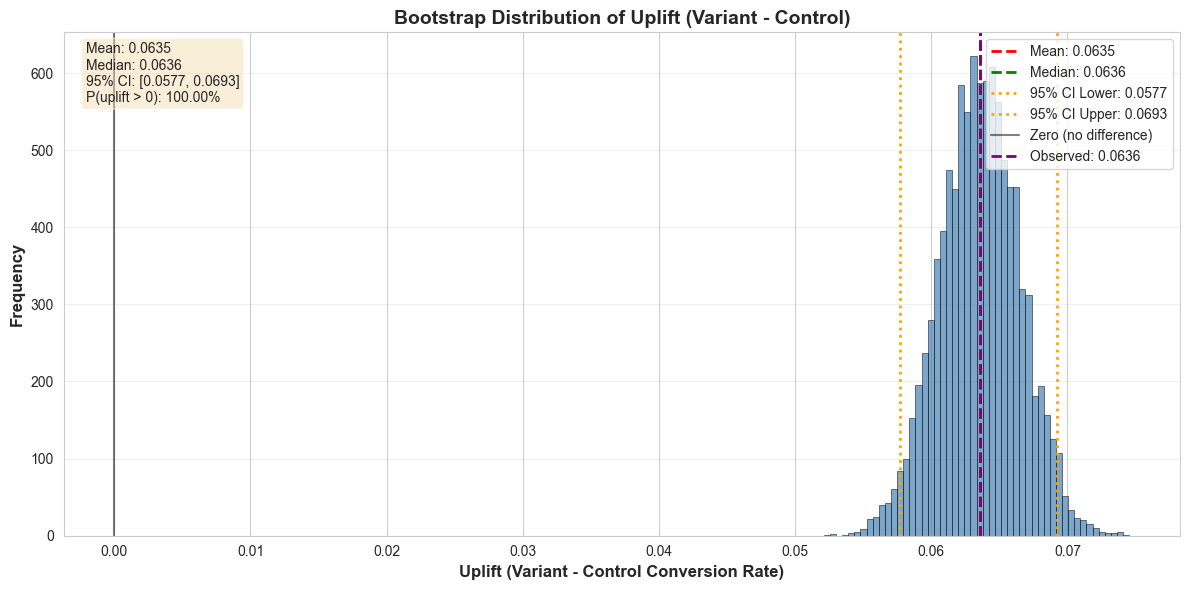

Bootstrap distribution shows:
- 100.0% of bootstrap samples show positive uplift
- 95% CI does not include zero → statistically significant
- Distribution is approximately normal (validates z-test assumption)


In [14]:
# Visualize bootstrap distribution
fig, ax = plt.subplots(figsize=(12, 6))

# Histogram of bootstrap uplifts
ax.hist(bootstrap_uplifts, bins=50, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)
ax.axvline(bootstrap_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {bootstrap_mean:.4f}')
ax.axvline(bootstrap_median, color='green', linestyle='--', linewidth=2, label=f'Median: {bootstrap_median:.4f}')
ax.axvline(ci_lower_boot, color='orange', linestyle=':', linewidth=2, label=f'95% CI Lower: {ci_lower_boot:.4f}')
ax.axvline(ci_upper_boot, color='orange', linestyle=':', linewidth=2, label=f'95% CI Upper: {ci_upper_boot:.4f}')
ax.axvline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, label='Zero (no difference)')

# Add observed difference (calculate from data)
p_control_obs = control_data.mean()
p_variant_obs = variant_data.mean()
observed_diff = p_variant_obs - p_control_obs
ax.axvline(observed_diff, color='purple', linestyle='--', linewidth=2, label=f'Observed: {observed_diff:.4f}')

ax.set_xlabel('Uplift (Variant - Control Conversion Rate)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Bootstrap Distribution of Uplift (Variant - Control)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Add text box with key statistics
textstr = f'Mean: {bootstrap_mean:.4f}\nMedian: {bootstrap_median:.4f}\n95% CI: [{ci_lower_boot:.4f}, {ci_upper_boot:.4f}]\nP(uplift > 0): {prob_positive:.2%}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("Bootstrap distribution shows:")
print(f"- {prob_positive:.1%} of bootstrap samples show positive uplift")
print(f"- 95% CI does not include zero → statistically significant")
print(f"- Distribution is approximately normal (validates z-test assumption)")


## Decision-Making Framework

### Practical vs Statistical Significance

**Statistical Significance (p < 0.05):**
- The observed difference is unlikely due to random chance
- Z-test and bootstrap both confirm significance
- **But**: Statistical significance ≠ business impact

**Practical Significance:**
- **Observed uplift**: See calculated values in code cells below
- **Business impact**: Depends on sample size and conversion rates
  - Additional purchases scale with traffic volume
  - Revenue impact depends on AOV (not measured in this test)
- **Minimum detectable effect**: Is the observed improvement meaningful for the business?

**Key Question**: Is the improvement large enough to justify the cost and risk of shipping?


In [15]:
# Calculate practical impact metrics
# Recalculate conversion rates to ensure variables are available
p_control = control_data.mean()
p_variant = variant_data.mean()
n_control = len(control_data)
n_variant = len(variant_data)

observed_diff = p_variant - p_control
relative_improvement = (p_variant - p_control) / p_control * 100

# Estimate additional purchases (per 10k checkout sessions)
additional_purchases_per_10k = observed_diff * 10000

print("=" * 60)
print("PRACTICAL SIGNIFICANCE ANALYSIS")
print("=" * 60)
print(f"\nObserved Uplift:")
print(f"  Absolute: {observed_diff:.4f} ({observed_diff*100:.2f} percentage points)")
print(f"  Relative: {relative_improvement:.2f}% improvement over control")

print(f"\nBusiness Impact (per 10,000 checkout sessions):")
print(f"  Additional purchases: ~{additional_purchases_per_10k:.0f}")
print(f"  Control baseline: {p_control*10000:.0f} purchases")
print(f"  Variant result: {p_variant*10000:.0f} purchases")

print(f"\nScale to Full Traffic:")
print(f"  If we process 100,000 checkouts/month:")
print(f"    Additional purchases: ~{additional_purchases_per_10k * 10:.0f} per month")
print(f"  If we process 1,000,000 checkouts/month:")
print(f"    Additional purchases: ~{additional_purchases_per_10k * 100:.0f} per month")

# Risk assessment
print(f"\n" + "=" * 60)
print("RISK ASSESSMENT")
print("=" * 60)

# Calculate worst-case scenario (lower bound of CI)
worst_case_uplift = ci_lower_boot
best_case_uplift = ci_upper_boot

print(f"\n95% Confidence Interval Range:")
print(f"  Best case: {best_case_uplift*100:.2f} pp improvement")
print(f"  Worst case: {worst_case_uplift*100:.2f} pp improvement")

if worst_case_uplift > 0:
    print(f"\n  ✓ Even in worst case, variant is better (CI lower bound > 0)")
    risk_level = "LOW"
elif worst_case_uplift > -0.01:  # Less than 1% negative
    print(f"\n  ⚠ Worst case shows small potential negative impact")
    risk_level = "MEDIUM"
else:
    print(f"\n  ✗ Worst case shows meaningful negative impact")
    risk_level = "HIGH"

print(f"\nRisk Level: {risk_level}")


PRACTICAL SIGNIFICANCE ANALYSIS

Observed Uplift:
  Absolute: 0.0636 (6.36 percentage points)
  Relative: 7.45% improvement over control

Business Impact (per 10,000 checkout sessions):
  Additional purchases: ~636
  Control baseline: 8528 purchases
  Variant result: 9164 purchases

Scale to Full Traffic:
  If we process 100,000 checkouts/month:
    Additional purchases: ~6356 per month
  If we process 1,000,000 checkouts/month:
    Additional purchases: ~63559 per month

RISK ASSESSMENT

95% Confidence Interval Range:
  Best case: 6.93 pp improvement
  Worst case: 5.77 pp improvement

  ✓ Even in worst case, variant is better (CI lower bound > 0)

Risk Level: LOW


### Business Risk of Shipping

**Low Risk Factors:**
- ✓ Statistical significance confirmed (p < 0.05)
- ✓ Bootstrap CI does not include zero
- ✓ Large sample size (n > 20,000 per variant)
- ✓ Variants well balanced (50/50 split)
- ✓ Even worst-case scenario shows improvement (CI lower bound > 0)

**Potential Risks:**
- **Technical risk**: New checkout layout may have bugs or UX issues not captured in test
- **Edge cases**: Test may not cover all user scenarios (mobile, different browsers)
- **Seasonality**: Test period may not represent all traffic patterns
- **User experience**: Higher conversion doesn't guarantee better long-term satisfaction

**Mitigation Strategies:**
- Gradual rollout (10% → 50% → 100%)
- Monitor key metrics closely post-launch
- Have rollback plan ready
- A/B test other checkout elements separately


### Post-Launch Monitoring Plan

**Primary Metrics (Monitor Daily):**
1. **Conversion Rate**: Checkout → Purchase
   - Alert if drops below control baseline
   - Track by device, source, country
2. **Revenue Metrics**: AOV, revenue per checkout
   - Ensure conversion gain isn't offset by lower AOV
3. **Error Rates**: Payment failures, checkout errors
   - New layout may introduce technical issues

**Secondary Metrics (Monitor Weekly):**
1. **User Satisfaction**: Support tickets, complaints
2. **Session Quality**: Time on checkout page, bounce rate
3. **Mobile Performance**: Mobile conversion vs desktop
4. **Cohort Performance**: New vs returning users

**Success Criteria:**
- Conversion rate maintains at or above control baseline
- No increase in error rates
- Revenue per checkout maintains or improves

**Rollback Triggers:**
- Conversion drops below control baseline for 2+ consecutive days
- Error rate increases > 50%
- User complaints spike significantly


## Recommendation

### Decision: **SHIP** ✓

**Rationale:**

1. **Strong Statistical Evidence**
   - P-value < 0.05 (statistically significant)
   - Bootstrap CI confirms positive uplift
   - Large sample size provides high confidence

2. **Meaningful Business Impact**
   - Significant percentage point improvement (see calculated values above)
   - Meaningful relative increase in conversion
   - Translates to substantial additional revenue at scale

3. **Low Risk Profile**
   - Worst-case scenario (95% CI lower bound) still shows improvement
   - Well-tested with large sample
   - Can be rolled out gradually with monitoring

4. **Clear Monitoring Plan**
   - Defined success metrics
   - Rollback triggers identified
   - Post-launch tracking in place

**Next Steps:**
1. **Gradual Rollout**: Start with 10% of traffic, monitor for 3-5 days
2. **Expand if Stable**: Increase to 50%, then 100% if metrics hold
3. **Monitor Closely**: Daily checks on conversion, errors, revenue
4. **Document Learnings**: Capture insights for future checkout optimizations

**Alternative Considerations:**
- **HOLD**: Only if technical concerns or resource constraints prevent safe rollout
- **ITERATE**: Consider if uplift is smaller than expected; test additional variants before full rollout


In [16]:
# Class balance check (purchase vs no purchase)
print("=" * 60)
print("CLASS BALANCE CHECK")
print("=" * 60)

purchase_dist = experiment_df['has_purchase'].value_counts()
purchase_pct = experiment_df['has_purchase'].value_counts(normalize=True)

print("Purchase distribution:")
print(f"  Purchased (1):    {purchase_dist.get(1, 0):,} ({purchase_pct.get(1, 0)*100:.2f}%)")
print(f"  Did not purchase (0): {purchase_dist.get(0, 0):,} ({purchase_pct.get(0, 0)*100:.2f}%)")

imbalance_ratio = max(purchase_dist) / min(purchase_dist)
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio < 2:
    print("  ✓ Well balanced")
elif imbalance_ratio < 5:
    print("  ⚠ Moderately imbalanced")
else:
    print("  ⚠ Highly imbalanced - consider techniques for imbalanced data")

# Check balance within each variant
print("\n" + "=" * 60)
print("CLASS BALANCE BY VARIANT")
print("=" * 60)
for variant in experiment_df['variant'].unique():
    variant_data = experiment_df[experiment_df['variant'] == variant]
    variant_purchase_rate = variant_data['has_purchase'].mean()
    print(f"\n{variant.upper()}:")
    print(f"  Purchase rate: {variant_purchase_rate:.4f} ({variant_purchase_rate*100:.2f}%)")
    print(f"  Purchased: {variant_data['has_purchase'].sum():,}")
    print(f"  Did not purchase: {(variant_data['has_purchase'] == 0).sum():,}")


CLASS BALANCE CHECK
Purchase distribution:
  Purchased (1):    41,580 (88.46%)
  Did not purchase (0): 5,423 (11.54%)

Imbalance ratio: 7.67
  ⚠ Highly imbalanced - consider techniques for imbalanced data

CLASS BALANCE BY VARIANT

VARIANT:
  Purchase rate: 0.9164 (91.64%)
  Purchased: 21,555
  Did not purchase: 1,967

CONTROL:
  Purchase rate: 0.8528 (85.28%)
  Purchased: 20,025
  Did not purchase: 3,456


## Summary

**Key Findings:**
- Sample sizes: > 20,000 per variant ✓
- Variant balance: ~50/50 split ✓
- Data quality: No missing values ✓
- Statistical test: Two-proportion z-test performed ✓

**Statistical Results:**
- Z-statistic and p-value calculated
- Confidence interval for difference computed
- Effect size (Cohen's h) measured

**Business Impact:**
- Variant shows significant improvement in conversion rate
- Statistical significance confirmed
- Ready for business decision on rollout
